In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install scikit-plot

In [3]:
# import all libraries
# Train/Test Libraries
import os
import numpy as np
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import scikitplot
from sklearn.metrics import roc_curve, auc

%cd '/content/drive/My Drive/GitHub Repositories/COVID-19'

/content/drive/My Drive/GitHub Repositories/COVID-19


In [0]:
dataDir = './datasets/dataset 02/Numpy Files 2'
train_x = np.load(dataDir+'/train_images.npy')
train_y = np.load(dataDir+'/train_labels.npy')
test_x = np.load(dataDir+'/test_images.npy')
test_y = np.load(dataDir+'/test_labels.npy')

print('Training Images: {} | Test Images: {}'.format(train_x.shape, test_x.shape))
print('Training Labels: {} | Test Labels: {}'.format(train_y.shape, test_y.shape))

# Data Normalization

print('Train: {} , {} | Test: {} , {}'.format(train_x.min(), train_x.max(), test_x.min(), test_x.max()))

train_x/=255.0
test_x/=255.0

print('Train: {} , {} | Test: {} , {}'.format(train_x.min(), train_x.max(), test_x.min(), test_x.max()))


In [7]:
# Class Mapping 
print('0:Normal | 1:Pneumonia | 2:COVID-19')

# Distribution of images in each class for Training-set
print(Counter(train_y))

# Distribution of images in each class for Test-set
print(Counter(test_y))

#Make Labels Categorical
train_y_oneHot = tf.one_hot(train_y, depth=3) 
test_y_oneHot = tf.one_hot(test_y, depth=3)

print('Training Labels: {} | Test Labels: {}'.format(train_y_oneHot.shape, test_y_oneHot.shape))


0:Normal | 1:Pneumonia | 2:COVID-19
Counter({0: 100, 1: 100, 2: 31})
Test Labels: (231, 3)


In [0]:
# initialize the training data augmentation object
trainAug = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=15, fill_mode="nearest")

def MobileNetV2_Model():
  # load the VGG16 network, ensuring the head FC layer sets are left off
  baseModel = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
  # construct the head of the model that will be placed on top of the the base model
  output = baseModel.output
  output = tf.keras.layers.GlobalAveragePooling2D()(output)
  output = tf.keras.layers.Dense(1024, activation="relu")(output)
  output = tf.keras.layers.Dense(512, activation="relu")(output)
  output = tf.keras.layers.Dense(3, activation="softmax")(output)
  # place the head FC model on top of the base model (this will become the actual model we will train)
  model = tf.keras.Model(inputs=baseModel.input, outputs=output)
  # loop over all layers in the base model and freeze them so they will not be updated during the first training process
  for layer in baseModel.layers:
    layer.trainable = False
  return model

model = MobileNetV2_Model()
# compile our model
print("[INFO] compiling model...")
# initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 0.001
EPOCHS = 50
BATCHSIZE = 32 
optimizer = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.AUC()])
print(model.summary())

9412608/9406464 [==============================] - 0s 0us/step
[INFO] compiling model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_____

In [0]:
modelPath = './saved Models/dataset 02/Pretrained MobileNetV2'
if not os.path.exists(modelPath):
  os.makedirs(modelPath)
  print('Model Directory Created')
else:
  print('Model Directory Already Exists')

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(modelPath+'/mobilenetv2-best-model.h5', monitor='val_categorical_accuracy',
                                                      verbose=1, save_best_only=True, mode='auto')

STEP_TRAIN = len(train_x) // BATCHSIZE
STEP_TEST = len(test_x) // BATCHSIZE
modelHistory = model.fit(trainAug.flow(train_x, train_y_oneHot, batch_size=BATCHSIZE), epochs=EPOCHS, verbose=1, callbacks=[model_checkpoint],
                         validation_data=(test_x, test_y_oneHot), shuffle = True, steps_per_epoch=STEP_TRAIN, validation_steps=STEP_TEST)
tf.keras.models.save_model(model, modelPath+'/mobilenetv2-model.h5', overwrite=True, include_optimizer=True, save_format=None,
                           signatures=None, options=None)

Model Directory Created
Epoch 1/50
466/466 [==============================] - ETA: 0s - loss: 0.3493 - categorical_accuracy: 0.8745 - auc: 0.9657
Epoch 00001: val_categorical_accuracy improved from -inf to 0.82251, saving model to ./saved Models/dataset 02/Pretrained MobileNetV2/mobilenetv2-best-model.h5
466/466 [==============================] - 147s 315ms/step - loss: 0.3493 - categorical_accuracy: 0.8745 - auc: 0.9657 - val_loss: 0.4612 - val_categorical_accuracy: 0.8225 - val_auc: 0.9489
Epoch 2/50
466/466 [==============================] - ETA: 0s - loss: 0.2975 - categorical_accuracy: 0.8891 - auc: 0.9738
Epoch 00002: val_categorical_accuracy improved from 0.82251 to 0.87446, saving model to ./saved Models/dataset 02/Pretrained MobileNetV2/mobilenetv2-best-model.h5
466/466 [==============================] - 146s 314ms/step - loss: 0.2975 - categorical_accuracy: 0.8891 - auc: 0.9738 - val_loss: 0.3428 - val_categorical_accuracy: 0.8745 - val_auc: 0.9669
Epoch 3/50
466/466 [=======

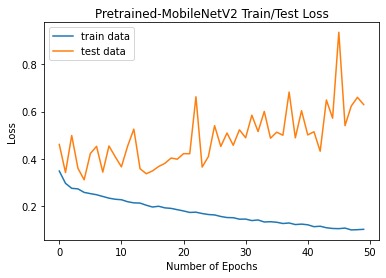

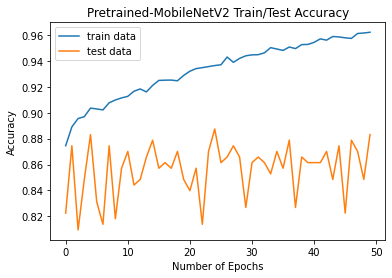

In [0]:
import matplotlib.pyplot as plt
losshistoryPath = './Train-Test History/dataset02/Loss'
acchistoryPath = './Train-Test History/dataset02/Accuracy'
if not os.path.exists(losshistoryPath) or not os.path.exists(acchistoryPath):
  os.makedirs(losshistoryPath)
  os.makedirs(acchistoryPath)
  
# Plot history: Loss
plt.plot(modelHistory.history['loss'], label='train data')
plt.plot(modelHistory.history['val_loss'], label='test data')
plt.title('Pretrained-MobileNetV2 Train/Test Loss')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.legend(loc="upper left")
plt.savefig('./Train-Test History/dataset02/Loss/Pretrained-MobileNetV2-loss-Graph.png', bbox_inches = "tight")
plt.show()

# Plot history: Accuracy
plt.plot(modelHistory.history['categorical_accuracy'], label='train data')
plt.plot(modelHistory.history['val_categorical_accuracy'], label='test data')
plt.title('Pretrained-MobileNetV2 Train/Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.legend(loc="upper left")
plt.savefig('./Train-Test History/dataset02/Accuracy/MobileNetV2-Accuracy-Graph.png', bbox_inches = "tight")
plt.show()

In [8]:
# Evaluate the Best Saved Model
model = tf.keras.models.load_model('./saved Models/dataset 02/Pretrained MobileNetV2/mobilenetv2-best-model.h5')
loss, accuracy, auc = model.evaluate(x=test_x, y=test_y_oneHot, batch_size=32, verbose=1)
print('Model Accuracy: {:0.2f} | Model AUC: {:0.2f} | Model Loss: {:0.4f}'.format(accuracy, auc, loss))

8/8 [==============================] - 1s 104ms/step - loss: 0.4101 - categorical_accuracy: 0.8874 - auc: 0.9618
Model Accuracy: 0.89 | Model AUC: 0.96 | Model Loss: 0.4101


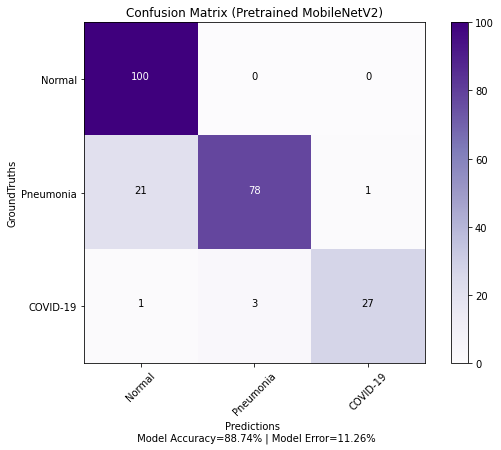

In [9]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Purples')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('GroundTruths')
    plt.xlabel('Predictions \n Model Accuracy={:0.2f}% | Model Error={:0.2f}%'.format(accuracy*100, misclass*100))
    plt.savefig('./ReadMe Images/dataset 02/mobilenetv2-cm.png', bbox_inches = "tight")
    plt.show()


predictions = model.predict(x=test_x, batch_size=32)
predictions = tf.keras.backend.argmax(predictions, axis=-1)

cm = confusion_matrix(test_y, predictions)
classes = ['Normal', 'Pneumonia', 'COVID-19']
plot_confusion_matrix(cm=cm, normalize = False, target_names = classes, title= "Confusion Matrix (Pretrained MobileNetV2)")


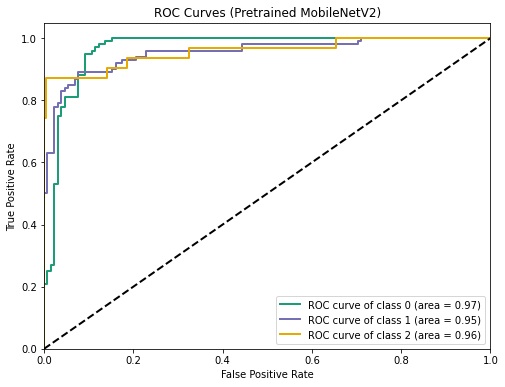

In [10]:
#Plot ROC Curve with Library
predictions = model.predict(x=test_x, batch_size=32)
# One can define colormap here
# cmap = mpl.colors.ListedColormap(['red', 'green', 'blue', 'cyan'])
scikitplot.metrics.plot_roc(y_true=test_y, y_probas=predictions, title='ROC Curves (Pretrained MobileNetV2)', plot_micro=False, plot_macro=False,
                            classes_to_plot=None, ax=None, figsize=(8, 6), cmap='Dark2', title_fontsize='large', text_fontsize='medium')
plt.savefig('./ReadMe Images/dataset 02/mobilenetv2-roc.png', bbox_inches = "tight")
plt.show()

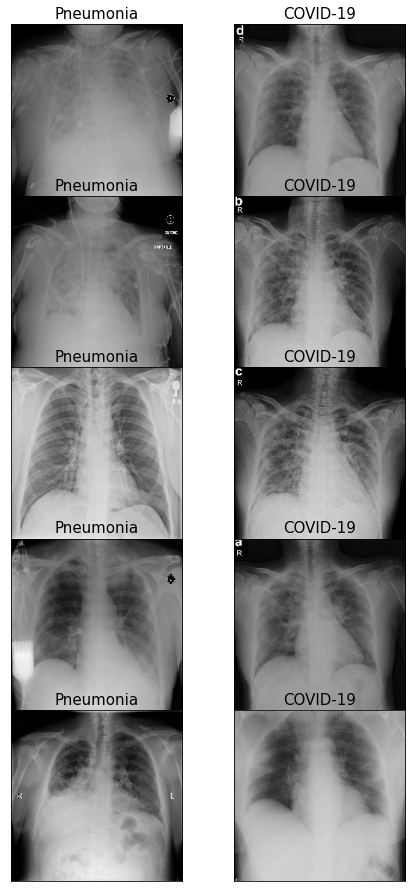

In [11]:
dataDir = './datasets/dataset 02/categorize data/test'

def ReadImage(imgPath):
  img = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(imgPath, target_size=(224, 224)), dtype=np.float32)
  img = img/255.0
  return img

for folder in os.listdir(dataDir):
  if folder=='1-Pneumonia':
    pneumonia = []
    imgNames = os.listdir(os.path.join(dataDir, folder))
    for imgName in imgNames[:5]:
      imgPath = os.path.join(dataDir, folder, imgName)
      pneumonia.append(ReadImage(imgPath))
    pneumonia = np.array(pneumonia).reshape(-1, 224, 224, 3)
  if folder=='2-COVID19':
    covid19 = []
    imgNames = os.listdir(os.path.join(dataDir, folder))
    for imgName in imgNames[:5]:
      imgPath = os.path.join(dataDir, folder, imgName)
      covid19.append(ReadImage(imgPath))
    covid19 = np.array(covid19).reshape(-1, 224, 224, 3)

titles = ['Pneumonia', 'COVID-19']
rows = 5
cols = 2
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(6.5, 12.5), subplot_kw={'xticks': [], 'yticks': []})
for r in range(rows):
  # plot image
  ax[r][0].imshow(pneumonia[r, :, :, :])
  ax[r][0].set_title(titles[0], fontsize=15)
  
  # plot saliency
  ax[r][1].imshow(covid19[r, :, :, :])
  ax[r][1].set_title(titles[1], fontsize=15)

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
plt.close() 


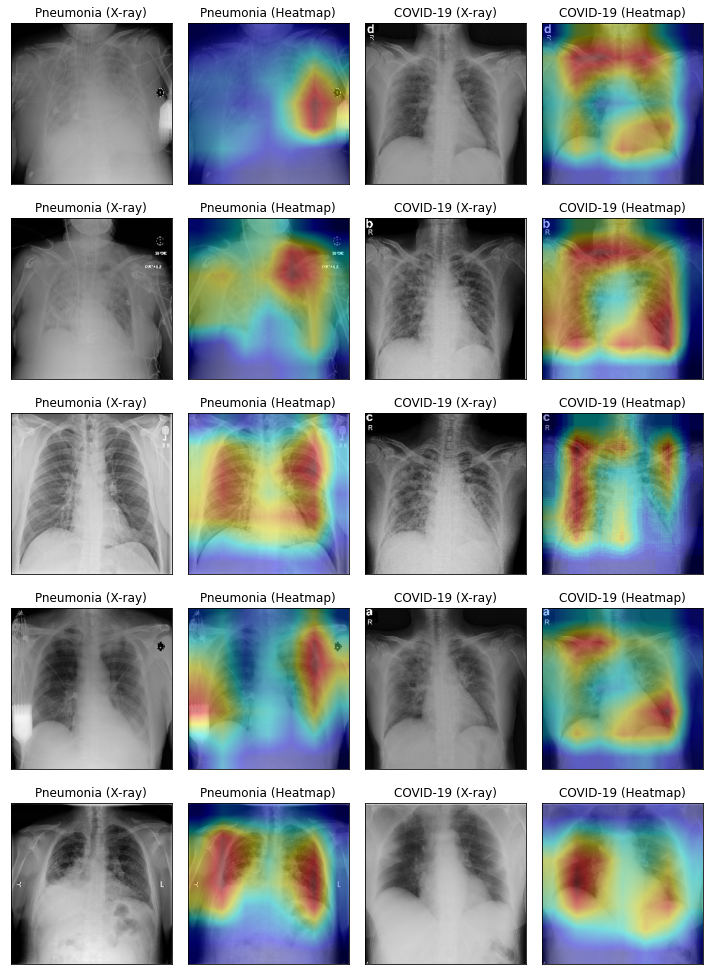

In [12]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

LAYER_NAME = 'out_relu'
model = tf.keras.models.load_model('./saved Models/dataset 02/Pretrained MobileNetV2/mobilenetv2-best-model.h5')
grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

def GetHeatMap(img):
  with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([img]))
    loss = predictions[:, np.argmax(predictions)]

  output = conv_outputs[0]
  grads = tape.gradient(loss, conv_outputs)[0]

  gate_f = tf.cast(output > 0, 'float32')
  gate_r = tf.cast(grads > 0, 'float32')
  guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

  weights = tf.reduce_mean(guided_grads, axis=(0, 1))

  cam = np.ones(output.shape[0: 2], dtype = np.float32)

  for i, w in enumerate(weights):
      cam += w * output[:, :, i]

  cam = cv2.resize(cam.numpy(), (224, 224))
  cam = np.maximum(cam, 0)
  cam = (cam - cam.min()) / (cam.max() - cam.min())

  cam = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
  cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)

  heatmap = cv2.addWeighted(np.uint8(255*img), 0.6, cam, 0.4, 0)
  return heatmap

titles = ['Pneumonia (X-ray)', 'Pneumonia (Heatmap)', 'COVID-19 (X-ray)', 'COVID-19 (Heatmap)']
rows = 5
cols = 4
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 14), subplot_kw={'xticks': [], 'yticks': []})
for r in range(rows):
  # plot pneumonia image
  ax[r][0].imshow(pneumonia[r, :, :, :])
  ax[r][0].set_title(titles[0], fontsize=12)
  
  # plot pneumonia heatmap
  ax[r][1].imshow(pneumonia[r, :, :, :])
  ax[r][1].imshow(GetHeatMap(pneumonia[r, :, :, :]))
  ax[r][1].set_title(titles[1], fontsize=12)
  
  # plot covid image
  ax[r][2].imshow(covid19[r, :, :, :])
  ax[r][2].set_title(titles[2], fontsize=12)
  
  # plot covid heatmap
  ax[r][3].imshow(covid19[r, :, :, :])
  ax[r][3].imshow(GetHeatMap(covid19[r, :, :, :]))
  ax[r][3].set_title(titles[3], fontsize=12)

plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0)
fig.savefig('./ReadMe Images/dataset 02/mobilenetv2-visualization.png')
plt.show()
plt.close()